<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Statistical-Description" data-toc-modified-id="Statistical-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Statistical Description</a></span></li><li><span><a href="#OF-Comparision" data-toc-modified-id="OF-Comparision-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>OF Comparision</a></span></li><li><span><a href="#TIME-Comparision" data-toc-modified-id="TIME-Comparision-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>TIME Comparision</a></span></li><li><span><a href="#Correlation-and-Machine-Leaning" data-toc-modified-id="Correlation-and-Machine-Leaning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Correlation and Machine Leaning</a></span><ul class="toc-item"><li><span><a href="#Correlation" data-toc-modified-id="Correlation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Correlation</a></span></li><li><span><a href="#Machine-Learning" data-toc-modified-id="Machine-Learning-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Machine Learning</a></span><ul class="toc-item"><li><span><a href="#NEWCBC_TIME-prediction" data-toc-modified-id="NEWCBC_TIME-prediction-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>NEWCBC_TIME prediction</a></span></li><li><span><a href="#CBC_TIME-prediction" data-toc-modified-id="CBC_TIME-prediction-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>CBC_TIME prediction</a></span></li><li><span><a href="#MODEL_TIME-prediction" data-toc-modified-id="MODEL_TIME-prediction-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>MODEL_TIME prediction</a></span></li><li><span><a href="#OF-Value-Prediction" data-toc-modified-id="OF-Value-Prediction-4.2.4"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>OF Value Prediction</a></span></li></ul></li></ul></li></ul></div>

In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as sqlF
from pyspark import SparkContext, SparkConf

In [2]:
from pyspark.ml import stat

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

We need to load crealytics package to load excel file in spark, to do so we load in while creating the sparkSession.

In [4]:
from pyspark.sql import SparkSession
my_spark = SparkSession \
    .builder \
    .appName("myApp").\
    config('spark.jars.packages','com.crealytics:spark-excel_2.11:0.12.2').getOrCreate()

In [5]:
#conf = (SparkConf().set("spark.jars", jar_path))
#conf = SparkConf().set("com.crealytics.spark.excel", "/home/jovyan/challange/*")

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [6]:
excel_reader = sqlContext.read.format("com.crealytics.spark.excel") \
                         .option("useHeader", "true") \
                         .option("treatEmptyValuesAsNulls", "false") \
                         .option("inferSchema", "true")

In [7]:
df1 = excel_reader.load('risultati_A_zaini_piccoli_9-11.xlsx')
df2 = excel_reader.load('risultati_B_piccole_45-55_1big_knapsack.xlsx')
df3 = excel_reader.load('risultati_C_piccole_45-55.xlsx')
df4 = excel_reader.load('risultati_D_con_più zaini.xlsx')
df5 = excel_reader.load('risultati_E_con_più items.xlsx')
df6 = excel_reader.load('risultati_F_zaini_piccoli_27-33.xlsx')

It load sometimes also the last line of the excel file, infact, in some of the excel file the last lines sometimes have an empty line, here is an example:

In [8]:
df2.toPandas().tail(3)

,F1,F2,F3,F4,Rep,MODEL_OF,MODEL_OFUB,MODEL_TIME,CBC_OF,CBC_TIME,CBC_FC,CBC_PC,NEWCBC_OF,NEWCBC_TIME,NEWCBC_FC
89,10.0,600.0,12.0,B,10.0,530.0,530.0,1967.77,530.0,2585.75,0.0,50.0,530.0,0.457,0.0
90,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We concatenate the dataframes and drop the artificially created NULL rows.

In [9]:
data = df1.union(df2).union(df3).union(df4).union(df5).union(df6).dropna()

In [10]:
# no more NA's yeaah!
data.count()

400

In [11]:
#it is a good practise to filter before converting to pandas to not occupy too much memory, 
#especially if it is needed to preview the table
data.limit(5).toPandas()

,F1,F2,F3,F4,Rep,MODEL_OF,MODEL_OFUB,MODEL_TIME,CBC_OF,CBC_TIME,CBC_FC,CBC_PC,NEWCBC_OF,NEWCBC_TIME,NEWCBC_FC
0,3.0,400.0,9.0,A,1.0,197.0,197.0,0.290,197.0,0.02,0.0,1.0,197.0,0.056,0.0
1,3.0,400.0,9.0,A,2.0,162.0,162.0,0.240,162.0,0.02,0.0,0.0,162.0,0.016,0.0
2,3.0,400.0,9.0,A,3.0,165.0,165.0,0.850,165.0,0.01,0.0,0.0,165.0,0.023,0.0
3,3.0,400.0,6.0,A,4.0,178.0,178.0,0.311,178.0,0.02,0.0,1.0,178.0,0.012,0.0
4,3.0,400.0,9.0,A,5.0,220.0,220.0,0.720,220.0,0.03,0.0,1.0,220.0,0.038,0.0


In [12]:
data.printSchema()

root
 |-- F1: double (nullable = true)
 |-- F2: double (nullable = true)
 |-- F3: double (nullable = true)
 |-- F4: string (nullable = true)
 |-- Rep: double (nullable = true)
 |-- MODEL_OF: double (nullable = true)
 |-- MODEL_OFUB: double (nullable = true)
 |-- MODEL_TIME: double (nullable = true)
 |-- CBC_OF: double (nullable = true)
 |-- CBC_TIME: double (nullable = true)
 |-- CBC_FC: double (nullable = true)
 |-- CBC_PC: double (nullable = true)
 |-- NEWCBC_OF: double (nullable = true)
 |-- NEWCBC_TIME: double (nullable = true)
 |-- NEWCBC_FC: double (nullable = true)



<b><i> There is no actual need to convert the spark's dataframe to pandas Dataframe, during the report with jupyter we will covert the result sometimes just because it makes it easier to read them, so basically we might use *.toPandas() instead of *.show(). The only time the convertion are essential is while doing the plots and the statistical test from scipy library. </b></i>

# Statistical Description 

Basic statistics for the data, not all of the defualt statistics given by spark make sense such as mean and stddev for non double values so only min and max is kept, F4 is left even though it's useless.

In [13]:
data.describe().filter("summary=='min' OR summary=='max'").toPandas()

,summary,F1,F2,F3,F4,Rep,MODEL_OF,MODEL_OFUB,MODEL_TIME,CBC_OF,CBC_TIME,CBC_FC,CBC_PC,NEWCBC_OF,NEWCBC_TIME,NEWCBC_FC
0,min,3.0,400.0,6.0,A,1.0,82.0,82.0,0.08,82.0,0.01,0.0,0.0,82.0,0.011,0.0
1,max,20.0,1000.0,19.0,F,10.0,658.0,658.0,3600.0,658.0,3600.0,5.0,255.0,658.0,1.562,0.0


In [14]:
data.describe('MODEL_TIME','CBC_TIME','NEWCBC_TIME','MODEL_OF','CBC_OF','NEWCBC_OF').toPandas()

,summary,MODEL_TIME,CBC_TIME,NEWCBC_TIME,MODEL_OF,CBC_OF,NEWCBC_OF
0,count,400,400,400,400,400,400
1,mean,293.39093499999996,254.80618250000003,0.19791250000000002,281.9075,281.8625,281.81
2,stddev,880.5823451249037,775.7127981301821,0.23503598581988636,102.20495867468578,102.186392149843,102.0867678517939
3,min,0.08,0.01,0.011,82.0,82.0,82.0
4,max,3600.0,3600.0,1.562,658.0,658.0,658.0


In [15]:
#check the values of F3
data.select('F3').groupBy('F3').count().show()

+----+-----+
|  F3|count|
+----+-----+
| 8.0|   63|
| 7.0|   40|
|18.0|    6|
|11.0|   28|
|14.0|    2|
|19.0|    2|
|10.0|   88|
|13.0|    7|
| 6.0|   18|
|15.0|    4|
| 9.0|   98|
|16.0|    3|
|12.0|   41|
+----+-----+



Checking if the number of experiments are 10 for each instance, except for F3 which is a number between 6 and 19.

In [16]:
data.select('F1','F2','F4').groupBy('F1','F2','F4').count().show()

+----+------+---+-----+
|  F1|    F2| F4|count|
+----+------+---+-----+
| 3.0| 600.0|  B|   10|
| 3.0| 500.0|  F|   10|
| 5.0| 400.0|  F|   10|
| 3.0| 600.0|  C|   10|
|10.0| 500.0|  B|   10|
| 5.0| 400.0|  C|   10|
|10.0| 600.0|  B|   10|
|10.0| 500.0|  C|   10|
| 3.0| 400.0|  F|   10|
|10.0| 500.0|  A|   10|
|10.0| 500.0|  F|   10|
|10.0|1000.0|  E|   10|
| 5.0| 600.0|  A|   10|
| 3.0| 400.0|  A|   10|
| 3.0| 600.0|  A|   10|
| 3.0| 500.0|  B|   10|
|10.0| 600.0|  A|   10|
| 3.0| 500.0|  C|   10|
|10.0| 400.0|  A|   10|
|15.0| 600.0|  D|   10|
+----+------+---+-----+
only showing top 20 rows



In [17]:
data.select('F1','F2','F4','MODEL_TIME','CBC_TIME','NEWCBC_TIME').\
    groupBy('F1','F2','F4').\
    agg(sqlF.mean('NEWCBC_TIME'),sqlF.mean('CBC_TIME'),sqlF.mean('MODEL_TIME'),
       sqlF.stddev('NEWCBC_TIME').alias('std(NEWCBC_TIME)'),sqlF.stddev('CBC_TIME').alias('std(CBC_TIME)'),
        sqlF.stddev('MODEL_TIME').alias('std(MODEL_TIME)')).toPandas()

,F1,F2,F4,avg(NEWCBC_TIME),avg(CBC_TIME),avg(MODEL_TIME),std(NEWCBC_TIME),std(CBC_TIME),std(MODEL_TIME)
0,3.0,600.0,B,0.0661,1.9698,4.6848,0.036647,1.723989,2.888417
1,3.0,500.0,F,0.0741,0.8320,1.8108,0.035174,1.021957,1.180559
2,5.0,400.0,F,0.0925,5.1808,6.0385,0.051945,7.370881,6.793985
3,3.0,600.0,C,0.0931,1.8041,4.9711,0.047811,1.339446,2.497119
4,10.0,500.0,B,0.3302,950.6025,659.9170,0.170374,1155.305135,1089.146031
5,5.0,400.0,C,0.0601,0.1070,0.4430,0.035943,0.242077,0.503765
6,10.0,600.0,B,0.3692,1534.8159,1948.7838,0.110893,971.315393,1510.426673
7,10.0,500.0,C,0.2121,0.1836,0.5624,0.320666,0.461366,0.422558
8,3.0,400.0,F,0.0318,0.2654,0.9585,0.016144,0.453144,0.726435
9,10.0,500.0,A,0.2487,3.2919,370.9224,0.134123,5.797864,1134.637312


Here we write down some basic statistics of OF, grouped by experiments (so we have less data to read)

In [18]:
data.select('F1','F2','F4','MODEL_OF','CBC_OF','NEWCBC_OF').groupBy('F1','F2','F4').\
    agg(sqlF.mean('NEWCBC_OF'),sqlF.mean('CBC_OF'),sqlF.mean('MODEL_OF'),
       sqlF.stddev('NEWCBC_OF').alias('std(NEWCBC_OF)'),sqlF.stddev('CBC_OF').alias('std(CBC_OF)'),
        sqlF.stddev('MODEL_OF').alias('std(MODEL_OF)')).toPandas()

,F1,F2,F4,avg(NEWCBC_OF),avg(CBC_OF),avg(MODEL_OF),std(NEWCBC_OF),std(CBC_OF),std(MODEL_OF)
0,3.0,600.0,B,384.8,384.8,384.8,72.207725,72.207725,72.207725
1,3.0,500.0,F,248.1,248.1,248.1,56.843743,56.843743,56.843743
2,5.0,400.0,F,211.3,211.3,211.3,59.160892,59.160892,59.160892
3,3.0,600.0,C,414.6,414.6,414.6,101.619333,101.619333,101.619333
4,10.0,500.0,B,322.7,322.7,322.7,44.287069,44.287069,44.287069
5,5.0,400.0,C,236.4,236.4,236.4,68.717134,68.717134,68.717134
6,10.0,600.0,B,382.5,382.5,382.5,76.520513,76.520513,76.520513
7,10.0,500.0,C,222.3,222.3,222.3,36.435788,36.435788,36.435788
8,3.0,400.0,F,234.7,234.7,234.7,40.702307,40.702307,40.702307
9,10.0,500.0,A,203.2,204.4,203.2,37.820629,38.108617,37.820629


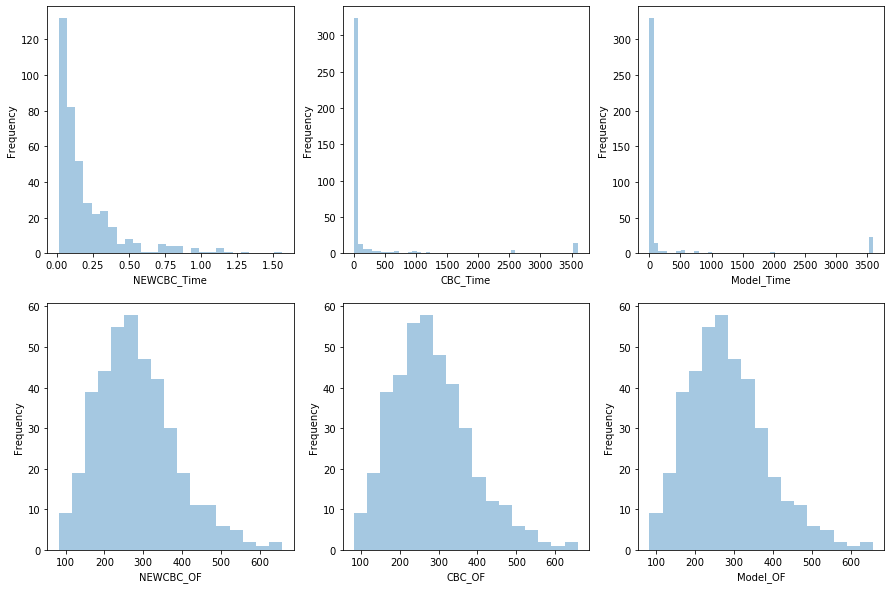

In [19]:
plt.figure(figsize=(15,10))
ax1 = plt.subplot(2, 3, 1)
sns.distplot(data.select('NEWCBC_TIME').toPandas(), kde=False, ax=ax1) 
plt.xlabel('NEWCBC_Time')
plt.ylabel('Frequency')


ax2 = plt.subplot(2, 3, 2)
sns.distplot(data.select('CBC_TIME').toPandas(), kde=False, ax=ax2) 
plt.xlabel('CBC_Time')
plt.ylabel('Frequency')

ax3 = plt.subplot(2, 3, 3)
sns.distplot(data.select('Model_TIME').toPandas(), kde=False, ax=ax3) 
plt.xlabel('Model_Time')
plt.ylabel('Frequency')

ax4 = plt.subplot(2, 3, 4)
sns.distplot(data.select('NEWCBC_OF').toPandas(), kde=False, ax=ax4) 
plt.xlabel('NEWCBC_OF')
plt.ylabel('Frequency')

ax5 = plt.subplot(2, 3, 5)
sns.distplot(data.select('CBC_OF').toPandas(), kde=False, ax=ax5) 
plt.xlabel('CBC_OF')
plt.ylabel('Frequency')

ax6 = plt.subplot(2, 3, 6)
sns.distplot(data.select('Model_OF').toPandas(), kde=False, ax=ax6) 
plt.xlabel('Model_OF')
plt.ylabel('Frequency')

plt.show()

plt.show()

# OF Comparision

Actually there is no need to use a test, in the table above we saw that the average and the standard deviation are very similar, so all three models performs achieves the same OF, we can also see in the histogram that the distributions are also the similar.

In [20]:
#We write it down again here
data.select('F1','F2','F4','MODEL_OF','CBC_OF','NEWCBC_OF').groupBy('F1','F2','F4').\
    agg(sqlF.mean('NEWCBC_OF'),sqlF.mean('CBC_OF'),sqlF.mean('MODEL_OF'),
       sqlF.stddev('NEWCBC_OF').alias('std(NEWCBC_OF)'),sqlF.stddev('CBC_OF').alias('std(CBC_OF)'),
        sqlF.stddev('MODEL_OF').alias('std(MODEL_OF)')).toPandas()

,F1,F2,F4,avg(NEWCBC_OF),avg(CBC_OF),avg(MODEL_OF),std(NEWCBC_OF),std(CBC_OF),std(MODEL_OF)
0,3.0,600.0,B,384.8,384.8,384.8,72.207725,72.207725,72.207725
1,3.0,500.0,F,248.1,248.1,248.1,56.843743,56.843743,56.843743
2,5.0,400.0,F,211.3,211.3,211.3,59.160892,59.160892,59.160892
3,3.0,600.0,C,414.6,414.6,414.6,101.619333,101.619333,101.619333
4,10.0,500.0,B,322.7,322.7,322.7,44.287069,44.287069,44.287069
5,5.0,400.0,C,236.4,236.4,236.4,68.717134,68.717134,68.717134
6,10.0,600.0,B,382.5,382.5,382.5,76.520513,76.520513,76.520513
7,10.0,500.0,C,222.3,222.3,222.3,36.435788,36.435788,36.435788
8,3.0,400.0,F,234.7,234.7,234.7,40.702307,40.702307,40.702307
9,10.0,500.0,A,203.2,204.4,203.2,37.820629,38.108617,37.820629


In [21]:
#The difference is very small, almost negligible
data.select('F1','F2','F4','MODEL_OF','CBC_OF','NEWCBC_OF').\
    agg(sqlF.mean('NEWCBC_OF'),sqlF.mean('CBC_OF'),sqlF.mean('MODEL_OF'),
       sqlF.stddev('NEWCBC_OF').alias('std(NEWCBC_OF)'),sqlF.stddev('CBC_OF').alias('std(CBC_OF)'),
        sqlF.stddev('MODEL_OF').alias('std(MODEL_OF)')).toPandas()

,avg(NEWCBC_OF),avg(CBC_OF),avg(MODEL_OF),std(NEWCBC_OF),std(CBC_OF),std(MODEL_OF)
0,281.81,281.8625,281.9075,102.086768,102.186392,102.204959


We try doing the non parametric equivalent of the ANOVA: Kruskal–test.

In [22]:
from scipy.stats import kruskal

_, p = kruskal(data.select('MODEL_OF').toPandas(),data.select('CBC_OF').toPandas(),
                data.select('NEWCBC_OF').toPandas())
print("> p-value:", p)

> p-value: 0.9999328209108904


We don't refuse the $H_0$ since we have a p-value = 1, so we can say that the three groups have the same median.

# TIME Comparision

In [23]:
data.select('F1','F2','F4','MODEL_TIME','CBC_TIME','NEWCBC_TIME').\
    groupBy('F1','F2','F4').\
    agg(sqlF.mean('NEWCBC_TIME'),sqlF.mean('CBC_TIME'),sqlF.mean('MODEL_TIME'),
       sqlF.stddev('NEWCBC_TIME').alias('std(NEWCBC_TIME)'),sqlF.stddev('CBC_TIME').alias('std(CBC_TIME)'),
        sqlF.stddev('MODEL_TIME').alias('std(MODEL_TIME)')).toPandas()

,F1,F2,F4,avg(NEWCBC_TIME),avg(CBC_TIME),avg(MODEL_TIME),std(NEWCBC_TIME),std(CBC_TIME),std(MODEL_TIME)
0,3.0,600.0,B,0.0661,1.9698,4.6848,0.036647,1.723989,2.888417
1,3.0,500.0,F,0.0741,0.8320,1.8108,0.035174,1.021957,1.180559
2,5.0,400.0,F,0.0925,5.1808,6.0385,0.051945,7.370881,6.793985
3,3.0,600.0,C,0.0931,1.8041,4.9711,0.047811,1.339446,2.497119
4,10.0,500.0,B,0.3302,950.6025,659.9170,0.170374,1155.305135,1089.146031
5,5.0,400.0,C,0.0601,0.1070,0.4430,0.035943,0.242077,0.503765
6,10.0,600.0,B,0.3692,1534.8159,1948.7838,0.110893,971.315393,1510.426673
7,10.0,500.0,C,0.2121,0.1836,0.5624,0.320666,0.461366,0.422558
8,3.0,400.0,F,0.0318,0.2654,0.9585,0.016144,0.453144,0.726435
9,10.0,500.0,A,0.2487,3.2919,370.9224,0.134123,5.797864,1134.637312


In [24]:
data.select('MODEL_TIME','CBC_TIME','NEWCBC_TIME').\
    agg(sqlF.mean('NEWCBC_TIME'),sqlF.mean('CBC_TIME'),sqlF.mean('MODEL_TIME'),
       sqlF.stddev('NEWCBC_TIME').alias('std(NEWCBC_TIME)'),sqlF.stddev('CBC_TIME').alias('std(CBC_TIME)'),
        sqlF.stddev('MODEL_TIME').alias('std(MODEL_TIME)')).toPandas()

,avg(NEWCBC_TIME),avg(CBC_TIME),avg(MODEL_TIME),std(NEWCBC_TIME),std(CBC_TIME),std(MODEL_TIME)
0,0.197913,254.806183,293.390935,0.235036,775.712798,880.582345


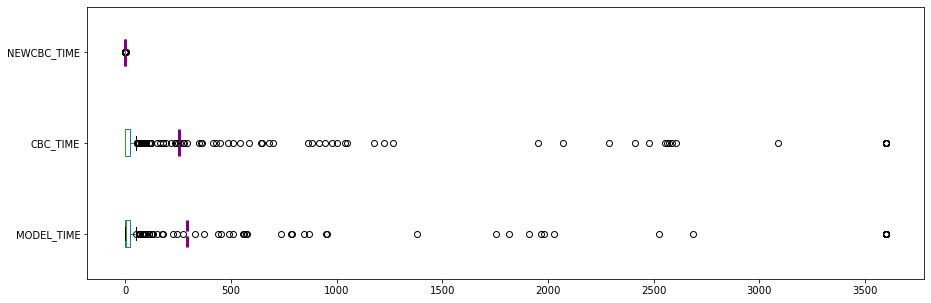

In [25]:
#the violet line is the mean
box_d= data.select('MODEL_TIME','CBC_TIME','NEWCBC_TIME').toPandas()
box_d.boxplot(column=['MODEL_TIME','CBC_TIME','NEWCBC_TIME'], grid=False,figsize=(15,5), 
              showmeans=True, meanline=True, meanprops={'color':'purple', 'linewidth':3}, vert=False)
plt.show()

The distributions are clearly non normal, there is not even the need of verify it using Shapiro-Wilks test for normality. Since the data is non normal we cannot use t-test or ANOVA test, we have to use the non-parametric kruskal test, to test it on two columns we will use the non parametric equivalent of the t-test: Mann-Whitney U test.

In [26]:
from scipy.stats import kruskal, mannwhitneyu

In [27]:
_, p = kruskal(data.select('MODEL_TIME').toPandas(),data.select('CBC_TIME').toPandas(),
                data.select('NEWCBC_TIME').toPandas())
print("> p-value:", p)

> p-value: 2.531376529390946e-95


In [28]:
_, p = mannwhitneyu(data.select('MODEL_TIME').toPandas()['MODEL_TIME'],
                data.select('CBC_TIME').toPandas()['CBC_TIME'])
print("> p-value:", p)

> p-value: 1.4763561231062497e-09


In [29]:
_, p = mannwhitneyu(data.select('NEWCBC_TIME').toPandas()['NEWCBC_TIME'],
                    data.select('MODEL_TIME').toPandas()['MODEL_TIME'])
print("> p-value:", p)

> p-value: 3.043885928956426e-108


In [30]:
_, p = mannwhitneyu(data.select('NEWCBC_TIME').toPandas()['NEWCBC_TIME'],
                    data.select('CBC_TIME').toPandas()['CBC_TIME'])
print("> p-value:", p)

> p-value: 5.058484003020759e-32


In all cases the $H_0$ are rejected, thus the medians are statistically different for all the 3 Models.

It is clear since all the algorithm achieved the same OF we cannot use it to determine which algorithm is better, using the TIME we deducted that the median of the 3 algorithms are different, so the best algorithm is NEWCBC which has the lowest execution time.  

# Correlation and Machine Leaning

## Correlation

In [31]:
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

In [32]:
#Note that all values are 0 for the FC, will drop it for the correlation matrix
data.select('NEWCBC_FC').groupBy('NEWCBC_FC').count().show()

+---------+-----+
|NEWCBC_FC|count|
+---------+-----+
|      0.0|  400|
+---------+-----+



In [33]:
data.select('F4').groupBy('F4').count().show()

+---+-----+
| F4|count|
+---+-----+
|  F|   90|
|  E|   20|
|  B|   90|
|  D|   20|
|  C|   90|
|  A|   90|
+---+-----+



Couldn't find an easy way to one hot encode F4 so will do it manually since there are only 6 classes.

In [34]:
data = data.withColumn('F4_A', sqlF.when(data["F4"]=="A",1).otherwise(0)).\
            withColumn('F4_B', sqlF.when(data["F4"]=="B",1).otherwise(0)).\
            withColumn('F4_C', sqlF.when(data["F4"]=="C",1).otherwise(0)).\
            withColumn('F4_D', sqlF.when(data["F4"]=="D",1).otherwise(0)).\
            withColumn('F4_E', sqlF.when(data["F4"]=="E",1).otherwise(0)).\
            withColumn('F4_F', sqlF.when(data["F4"]=="F",1).otherwise(0))

In [35]:
corrColumns = ['F1','F2','F3','F4_A','F4_B','F4_C','F4_D','F4_E','F4_F',
               'MODEL_OF','MODEL_OFUB','MODEL_TIME','CBC_OF',
               'CBC_TIME','CBC_FC','CBC_PC','NEWCBC_OF','NEWCBC_TIME']
data2 = data.select(corrColumns)

assembler = VectorAssembler(inputCols=data2.columns, outputCol="features")

In [36]:
assembler.transform(data2).select('features').show()

+--------------------+
|            features|
+--------------------+
|[3.0,400.0,9.0,1....|
|[3.0,400.0,9.0,1....|
|[3.0,400.0,9.0,1....|
|[3.0,400.0,6.0,1....|
|[3.0,400.0,9.0,1....|
|[3.0,400.0,7.0,1....|
|[3.0,400.0,8.0,1....|
|[3.0,400.0,7.0,1....|
|[3.0,400.0,10.0,1...|
|[3.0,400.0,8.0,1....|
|[3.0,500.0,8.0,1....|
|[3.0,500.0,8.0,1....|
|[3.0,500.0,9.0,1....|
|[3.0,500.0,10.0,1...|
|[3.0,500.0,9.0,1....|
|[3.0,500.0,9.0,1....|
|[3.0,500.0,10.0,1...|
|[3.0,500.0,10.0,1...|
|[3.0,500.0,10.0,1...|
|[3.0,500.0,8.0,1....|
+--------------------+
only showing top 20 rows



In [37]:
data4corr = assembler.transform(data2).select('features')
pearsonCorr = Correlation.corr(data4corr, 'features', 'pearson').collect()[0][0]

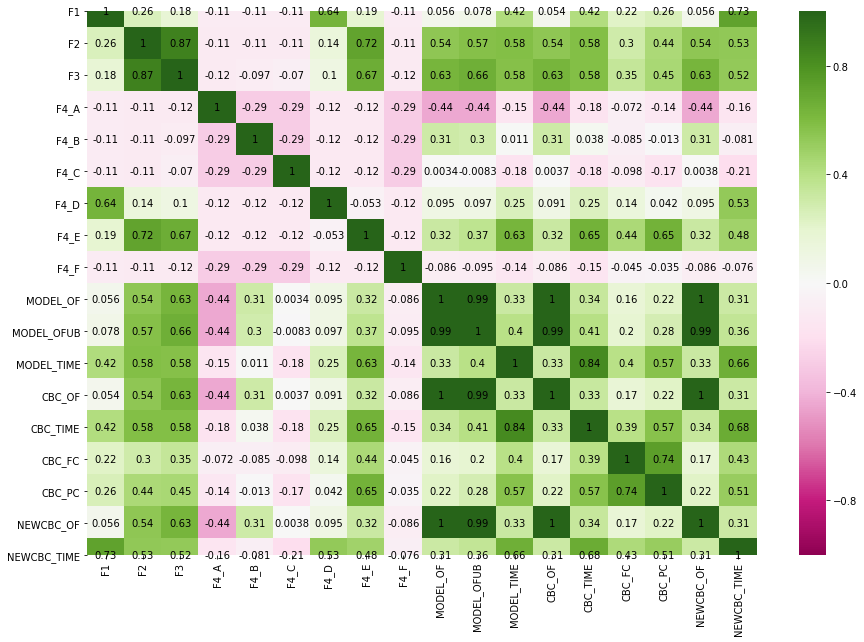

In [38]:
plt.figure(figsize=(15, 10))
sns.heatmap(pearsonCorr.values.reshape(len(corrColumns),len(corrColumns)), 
            vmax=1, vmin=-1, annot=True,annot_kws={'color':'black'},
           xticklabels=corrColumns, yticklabels=corrColumns, center=0, cmap="PiYG")
plt.show()

We immediately note that OF values have perfect correlation, TIME values are also highly correlated. 


## Machine Learning

F4 column must be one-hot encoded because it is a categorical feature with 6 levels.

In [39]:
assembler1 = VectorAssembler(
    inputCols=['F1','F2','F3','F4_A','F4_B','F4_C','F4_D','F4_E','F4_F'],
    outputCol='features')

In [40]:
df = assembler1.transform(data.select('F1','F2','F3','F4_A','F4_B','F4_C','F4_D','F4_E','F4_F'
                                      ,'MODEL_TIME','CBC_TIME','NEWCBC_TIME','MODEL_OF'))

In [41]:
df.show()

+---+-----+----+----+----+----+----+----+----+----------+--------+-----------+--------+--------------------+
| F1|   F2|  F3|F4_A|F4_B|F4_C|F4_D|F4_E|F4_F|MODEL_TIME|CBC_TIME|NEWCBC_TIME|MODEL_OF|            features|
+---+-----+----+----+----+----+----+----+----+----------+--------+-----------+--------+--------------------+
|3.0|400.0| 9.0|   1|   0|   0|   0|   0|   0|      0.29|    0.02|      0.056|   197.0|(9,[0,1,2,3],[3.0...|
|3.0|400.0| 9.0|   1|   0|   0|   0|   0|   0|      0.24|    0.02|      0.016|   162.0|(9,[0,1,2,3],[3.0...|
|3.0|400.0| 9.0|   1|   0|   0|   0|   0|   0|      0.85|    0.01|      0.023|   165.0|(9,[0,1,2,3],[3.0...|
|3.0|400.0| 6.0|   1|   0|   0|   0|   0|   0|     0.311|    0.02|      0.012|   178.0|(9,[0,1,2,3],[3.0...|
|3.0|400.0| 9.0|   1|   0|   0|   0|   0|   0|      0.72|    0.03|      0.038|   220.0|(9,[0,1,2,3],[3.0...|
|3.0|400.0| 7.0|   1|   0|   0|   0|   0|   0|     1.085|    0.03|      0.014|   162.0|(9,[0,1,2,3],[3.0...|
|3.0|400.0| 8.0|   

In [42]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features").fit(df)
df = scaler.transform(df)

In [43]:
train, test = df.randomSplit([.7,.3], seed=1234)

In [44]:
train.toPandas()

,F1,F2,F3,F4_A,F4_B,F4_C,F4_D,F4_E,F4_F,MODEL_TIME,CBC_TIME,NEWCBC_TIME,MODEL_OF,features,scaled_features
0,3.0,400.0,8.0,1,0,0,0,0,0,0.190,0.050,0.074,156.0,"(3.0, 400.0, 8.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[0.0, 0.0, 0.15384615384615385, 1.0, 0.0, 0.0,..."
1,3.0,400.0,8.0,1,0,0,0,0,0,1.580,0.050,0.092,108.0,"(3.0, 400.0, 8.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[0.0, 0.0, 0.15384615384615385, 1.0, 0.0, 0.0,..."
2,3.0,400.0,9.0,1,0,0,0,0,0,0.240,0.020,0.016,162.0,"(3.0, 400.0, 9.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[0.0, 0.0, 0.23076923076923078, 1.0, 0.0, 0.0,..."
3,3.0,400.0,9.0,1,0,0,0,0,0,0.290,0.020,0.056,197.0,"(3.0, 400.0, 9.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[0.0, 0.0, 0.23076923076923078, 1.0, 0.0, 0.0,..."
4,3.0,400.0,9.0,1,0,0,0,0,0,0.720,0.030,0.038,220.0,"(3.0, 400.0, 9.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[0.0, 0.0, 0.23076923076923078, 1.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,10.0,600.0,10.0,0,0,0,0,0,1,128.612,119.983,0.261,235.0,"(10.0, 600.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","[0.4117647058823529, 0.3333333333333333, 0.307..."
279,10.0,600.0,10.0,0,0,0,0,0,1,437.805,83.060,0.359,258.0,"(10.0, 600.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","[0.4117647058823529, 0.3333333333333333, 0.307..."
280,10.0,600.0,12.0,0,0,0,0,0,1,228.021,233.490,0.341,281.0,"(10.0, 600.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","[0.4117647058823529, 0.3333333333333333, 0.461..."
281,10.0,600.0,12.0,0,0,0,0,0,1,329.996,348.933,0.501,296.0,"(10.0, 600.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","[0.4117647058823529, 0.3333333333333333, 0.461..."


### NEWCBC_TIME prediction

Trying different models

In [45]:
from  pyspark.ml.regression import LinearRegression, GBTRegressor, GeneralizedLinearRegression, RandomForestRegressor
lr = LinearRegression(featuresCol = 'scaled_features', labelCol = 'NEWCBC_TIME')
lr_model = lr.fit(train)

gbt = GBTRegressor(featuresCol = 'scaled_features', labelCol = 'NEWCBC_TIME')
gbt_model = gbt.fit(train)

glr = GeneralizedLinearRegression(featuresCol = 'scaled_features', labelCol = 'NEWCBC_TIME')
glr_model = glr.fit(train)

rf = RandomForestRegressor(featuresCol = 'scaled_features', labelCol = 'NEWCBC_TIME')
rf_model = rf.fit(train)

In [46]:
from pyspark.ml.evaluation import RegressionEvaluator

lr_pred = lr_model.transform(test)
gbt_pred = gbt_model.transform(test)
glr_pred = glr_model.transform(test)
rf_pred = rf_model.transform(test)

ev = RegressionEvaluator(predictionCol='prediction',labelCol='NEWCBC_TIME')

print("RMSE lr: %f" % ev.evaluate(lr_pred,{ev.metricName: "rmse"}))
print("r2 lr: %f" % ev.evaluate(lr_pred,{ev.metricName: "r2"}))
print("")
print("RMSE gbt: %f" % ev.evaluate(gbt_pred,{ev.metricName: "rmse"}))
print("r2 gbt: %f" % ev.evaluate(gbt_pred,{ev.metricName: "r2"}))
print("")
print("RMSE glr: %f" % ev.evaluate(glr_pred,{ev.metricName: "rmse"}))
print("r2 glr: %f" % ev.evaluate(glr_pred,{ev.metricName: "r2"}))
print("")
print("RMSE rf: %f" % ev.evaluate(rf_pred,{ev.metricName: "rmse"}))
print("r2 rf: %f" % ev.evaluate(rf_pred,{ev.metricName: "r2"}))

RMSE lr: 0.105796
r2 lr: 0.785116

RMSE gbt: 0.105321
r2 gbt: 0.787040

RMSE glr: 0.105796
r2 glr: 0.785116

RMSE rf: 0.107896
r2 rf: 0.776499


### CBC_TIME prediction

In [47]:
from  pyspark.ml.regression import LinearRegression, GBTRegressor, GeneralizedLinearRegression, RandomForestRegressor
lr = LinearRegression(featuresCol = 'scaled_features', labelCol = 'CBC_TIME')
lr_model = lr.fit(train)

gbt = GBTRegressor(featuresCol = 'scaled_features', labelCol = 'CBC_TIME')
gbt_model = gbt.fit(train)

glr = GeneralizedLinearRegression(featuresCol = 'scaled_features', labelCol = 'CBC_TIME')
glr_model = glr.fit(train)

rf = RandomForestRegressor(featuresCol = 'scaled_features', labelCol = 'CBC_TIME')
rf_model = rf.fit(train)

In [48]:
from pyspark.ml.evaluation import RegressionEvaluator

lr_pred = lr_model.transform(test)
gbt_pred = gbt_model.transform(test)
glr_pred = glr_model.transform(test)
rf_pred = rf_model.transform(test)

ev = RegressionEvaluator(predictionCol='prediction',labelCol='CBC_TIME')

print("RMSE lr: %f" % ev.evaluate(lr_pred,{ev.metricName: "rmse"}))
print("r2 lr: %f" % ev.evaluate(lr_pred,{ev.metricName: "r2"}))
print("")
print("RMSE gbt: %f" % ev.evaluate(gbt_pred,{ev.metricName: "rmse"}))
print("r2 gbt: %f" % ev.evaluate(gbt_pred,{ev.metricName: "r2"}))
print("")
print("RMSE glr: %f" % ev.evaluate(glr_pred,{ev.metricName: "rmse"}))
print("r2 glr: %f" % ev.evaluate(glr_pred,{ev.metricName: "r2"}))
print("")
print("RMSE rf: %f" % ev.evaluate(rf_pred,{ev.metricName: "rmse"}))
print("r2 rf: %f" % ev.evaluate(rf_pred,{ev.metricName: "r2"}))

RMSE lr: 447.832179
r2 lr: 0.543182

RMSE gbt: 351.134618
r2 gbt: 0.719159

RMSE glr: 447.832179
r2 glr: 0.543182

RMSE rf: 381.731526
r2 rf: 0.668084


### MODEL_TIME prediction

In [49]:
from  pyspark.ml.regression import LinearRegression, GBTRegressor, GeneralizedLinearRegression, RandomForestRegressor
lr = LinearRegression(featuresCol = 'scaled_features', labelCol = 'MODEL_TIME')
lr_model = lr.fit(train)

gbt = GBTRegressor(featuresCol = 'scaled_features', labelCol = 'MODEL_TIME')
gbt_model = gbt.fit(train)

glr = GeneralizedLinearRegression(featuresCol = 'scaled_features', labelCol = 'MODEL_TIME')
glr_model = glr.fit(train)

rf = RandomForestRegressor(featuresCol = 'scaled_features', labelCol = 'MODEL_TIME')
rf_model = rf.fit(train)

In [50]:
from pyspark.ml.evaluation import RegressionEvaluator

lr_pred = lr_model.transform(test)
gbt_pred = gbt_model.transform(test)
glr_pred = glr_model.transform(test)
rf_pred = rf_model.transform(test)

ev = RegressionEvaluator(predictionCol='prediction',labelCol='MODEL_TIME')

print("RMSE lr: %f" % ev.evaluate(lr_pred,{ev.metricName: "rmse"}))
print("r2 lr: %f" % ev.evaluate(lr_pred,{ev.metricName: "r2"}))
print("")
print("RMSE gbt: %f" % ev.evaluate(gbt_pred,{ev.metricName: "rmse"}))
print("r2 gbt: %f" % ev.evaluate(gbt_pred,{ev.metricName: "r2"}))
print("")
print("RMSE glr: %f" % ev.evaluate(glr_pred,{ev.metricName: "rmse"}))
print("r2 glr: %f" % ev.evaluate(glr_pred,{ev.metricName: "r2"}))
print("")
print("RMSE rf: %f" % ev.evaluate(rf_pred,{ev.metricName: "rmse"}))
print("r2 rf: %f" % ev.evaluate(rf_pred,{ev.metricName: "r2"}))

RMSE lr: 410.062656
r2 lr: 0.640700

RMSE gbt: 333.528814
r2 gbt: 0.762303

RMSE glr: 410.062655
r2 glr: 0.640700

RMSE rf: 279.586332
r2 rf: 0.832972


### OF Value Prediction

In [51]:
from  pyspark.ml.regression import LinearRegression, GBTRegressor, GeneralizedLinearRegression, RandomForestRegressor
lr = LinearRegression(featuresCol = 'scaled_features', labelCol = 'MODEL_OF')
lr_model = lr.fit(train)

gbt = GBTRegressor(featuresCol = 'scaled_features', labelCol = 'MODEL_OF')
gbt_model = gbt.fit(train)

glr = GeneralizedLinearRegression(featuresCol = 'scaled_features', labelCol = 'MODEL_OF')
glr_model = glr.fit(train)

rf = RandomForestRegressor(featuresCol = 'scaled_features', labelCol = 'MODEL_OF')
rf_model = rf.fit(train)

In [52]:
from pyspark.ml.evaluation import RegressionEvaluator

lr_pred = lr_model.transform(test)
gbt_pred = gbt_model.transform(test)
glr_pred = glr_model.transform(test)
rf_pred = rf_model.transform(test)

ev = RegressionEvaluator(predictionCol='prediction',labelCol='MODEL_OF')

print("RMSE lr: %f" % ev.evaluate(lr_pred,{ev.metricName: "rmse"}))
print("r2 lr: %f" % ev.evaluate(lr_pred,{ev.metricName: "r2"}))
print("")
print("RMSE gbt: %f" % ev.evaluate(gbt_pred,{ev.metricName: "rmse"}))
print("r2 gbt: %f" % ev.evaluate(gbt_pred,{ev.metricName: "r2"}))
print("")
print("RMSE glr: %f" % ev.evaluate(glr_pred,{ev.metricName: "rmse"}))
print("r2 glr: %f" % ev.evaluate(glr_pred,{ev.metricName: "r2"}))
print("")
print("RMSE rf: %f" % ev.evaluate(rf_pred,{ev.metricName: "rmse"}))
print("r2 rf: %f" % ev.evaluate(rf_pred,{ev.metricName: "r2"}))

RMSE lr: 60.494274
r2 lr: 0.614387

RMSE gbt: 62.340363
r2 gbt: 0.590493

RMSE glr: 60.494274
r2 glr: 0.614387

RMSE rf: 59.768491
r2 rf: 0.623585


In predictions, at least one of the models achieves a decent $R^2$ score, so it is able to explain a lot of the variance in the predicted variable.